# House Price Prediction Using Linear Regression

The data I will be using for this exercise was taken from Kaggle competition assigment. It is split into 2 datasets (train.csv and test.csv). Both datasets contain 79 (categorical and numerical) independent variables, pricing variable contained only in the test.csv dataset. The aim of the asigment is to build a liear regression model predicting the house prices in the test.csv dataset.

Below I have built a linear regression model using the "train.xlsx" data set to predict house prices in "test.xlsx" dataset in R. This project is organized as follows: (1) data cleaning; (2) Exploratory Data Analysis (EDA); (3) LR model optimisation; (4) validation of the RL model; (5) running LR model on test.csv dataset.

# Loading Packages and Datasets

In [2]:
install.packages(c("lattice", "tidyverse", "ggplot2", "repr", "hexbin", "cowplot", "corrplot", "dplyr","gridExtra", "e1071")) 

library(lattice)
library(repr)
library(tidyverse)
library(ggplot2)
library(hexbin)
library(cowplot)
library(corrplot)
library(dplyr)
library(gridExtra)
library(e1071) 

In [98]:
options(warn = -1) 

In [99]:
test = read.csv("/Users/migle0703/miniconda3/bin/Predicting House Prices Regression in R/test.csv", stringsAsFactors = FALSE)
train = read.csv("/Users/migle0703/miniconda3/bin/Predicting House Prices Regression in R/train explore.csv", stringsAsFactors = FALSE)

# 1 ) Data Cleaning

* Combining both data sets together for more convenient data cleaning
* Finding columns with missing values and filling them accordingly (refering to "data_description.txt" file)

In [100]:
# test dataset has no “Saleprice” variable - filling it with NA for easier data processing 
test$SalePrice<-rep(NA,1459)
Data<-bind_rows(train,test)

In [101]:
# getting names of the columns containing NA values 
colnames(Data)[colSums(is.na(Data)) > 0]

[1] "MSZoning"     "LotFrontage"  "Alley"        "Utilities"    "Exterior1st" 
 [6] "Exterior2nd"  "MasVnrType"   "MasVnrArea"   "BsmtQual"     "BsmtCond"    
[11] "BsmtExposure" "BsmtFinType1" "BsmtFinSF1"   "BsmtFinType2" "BsmtFinSF2"  
[16] "BsmtUnfSF"    "TotalBsmtSF"  "Electrical"   "BsmtFullBath" "BsmtHalfBath"
[21] "KitchenQual"  "Functional"   "FireplaceQu"  "GarageType"   "GarageYrBlt" 
[26] "GarageFinish" "GarageCars"   "GarageArea"   "GarageQual"   "GarageCond"  
[31] "PoolQC"       "Fence"        "MiscFeature"  "SaleType"     "SalePrice"

In [102]:
# filling in NA values 

# Most common 
Data$MSZoning[is.na(Data$MSZoning)] = "RL"

#replacing NA with median
Data$LotFrontage[is.na(Data$LotFrontage)] = median(Data$LotFrontage, na.rm = TRUE)

# NA means no access 
Data$Alley[is.na(Data$Alley)] = "No alley access"

# majority are AllPub
Data$Utilities[is.na(Data$Utilities)] = "AllPub"

# replacing NA with None
Data$MasVnrType[is.na(Data$MasVnrType)] = "None"

# missing values cannot be reasonably estimated. Replacing NA by a numeric but non-sensical value such as -5000. 
Data$MasVnrArea[is.na(Data$MasVnrArea)] = -5000
Data$GarageYrBlt[is.na(Data$GarageYrBlt)] = -5000

# NA indicates no basement
Data$BsmtQual[is.na(Data$BsmtQual)] = "No bsmt"
Data$BsmtCond[is.na(Data$BsmtCond)] = "No bsmt"
Data$BsmtExposure[is.na(Data$BsmtExposure)] = "No bsmt"
Data$BsmtFinType1[is.na(Data$BsmtFinType1)] = "No bsmt"
Data$BsmtFinType2[is.na(Data$BsmtFinType2)] = "No bsmt"
Data$BsmtFinSF1[is.na(Data$BsmtFinSF1)] = "No bsmt"
Data$BsmtFinSF2[is.na(Data$BsmtFinSF2)] = "No bsmt"

# majority is Typ
Data$Functional[is.na(Data$Functional)] = "Typ"

#Replacing NA with SBrkr, which is most frequently occuring electrical set-up
Data$Electrical[is.na(Data$Electrical)] = "SBrkr"

#NA means no fireplace
Data$FireplaceQu[is.na(Data$FireplaceQu)] = "No fireplace"

#NA means no garage
Data$GarageType[is.na(Data$GarageType)] = "No garage"
Data$GarageFinish[is.na(Data$GarageFinish)] = "No garage"
Data$GarageQual[is.na(Data$GarageQual)] = "No garage"
Data$GarageCond[is.na(Data$GarageCond)] = "No garage"

# NA means no pool
Data$PoolQC[is.na(Data$PoolQC)] = "No pool"

# NA means no fence
Data$Fence[is.na(Data$Fence)] = "No fence"

# NA means none
Data$MiscFeature[is.na(Data$MiscFeature)] = "None"

# majortity is WD
Data$SaleType[is.na(Data$SaleType)] = "WD"

# removing NA values
Data <- Data[!is.na(Data$Exterior1st), ]
Data <- Data[!is.na(Data$BsmtFinSF1), ]
Data <- Data[!is.na(Data$BsmtFullBath), ]
Data <- Data[!is.na(Data$KitchenQual), ]
Data <- Data[!is.na(Data$GarageYrBlt), ]
Data <- Data[!is.na(Data$GarageArea), ]

In [103]:
colnames(Data)[colSums(is.na(Data)) > 0]

[1] "SalePrice"

In [104]:
# checking dataset it seems that BsmtFinSF2 and BsmtFinSF2 are labeled as char even though they are numeric variables
# converting them both columns to numeric 
Data <- transform(Data, BsmtFinSF1 = as.numeric(BsmtFinSF1))
Data <- transform(Data, BsmtFinSF2 = as.numeric(BsmtFinSF2))

# 2) Exploratory Data Analysis (EDA)

* Obtaining basic statistics of SalePrice

* Visualising categorical and numerical values


In [105]:
# seperating dataset back to train and test subsets. Using test dataset for EDA, 
# since train dataset will be used to build and optimise the model 
test_data <- Data[is.na(Data$SalePrice), ]  
train_data <- Data[!is.na(Data$SalePrice), ]  

In [106]:
#basic stats of dependant varilable - SalePrice
mean <- round(mean(train_data$SalePrice), 0)
std <- round(sd(train_data$SalePrice), 0)
min <- min(train_data$SalePrice)
max <- max(train_data$SalePrice)

data.frame(mean, std, min, max)

mean   std   min   max   
1 180921 79443 34900 755000

In [107]:
# Price distribution
disstribution <- ggplot(train_data, aes(x=SalePrice)) + 
  geom_histogram(color="black", fill="white")

#Price based on different neighborhoods
neighborhood <- ggplot(train_data, aes(x=reorder(Neighborhood, SalePrice, na.rm = TRUE), y=SalePrice, color = Neighborhood)) + 
    geom_boxplot() + theme(legend.key.size = unit(0.02, 'cm'),
                      legend.key.width= unit(0.001, 'cm'),
                      legend.title = element_text(size=9),
                      legend.text = element_text(size=6),
                      axis.text.x = element_text(angle = 90, size = 7,hjust =1))

# YearBuilt and OverallQual: Rates the overall material and finish of the house
quality <- ggplot(train_data, aes(x=YearBuilt, y=SalePrice, color = OverallQual)) +
  geom_point(size=2, shape=23) + geom_smooth(method=lm, color="darkred")

# YearBuilt and SaleCondition: Condition of sale
sale_cond <- ggplot(train_data, aes(x=YearBuilt, y=SalePrice, color = SaleCondition)) +
  geom_point(size=2, shape=23) + geom_smooth(method=lm, color="darkred")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


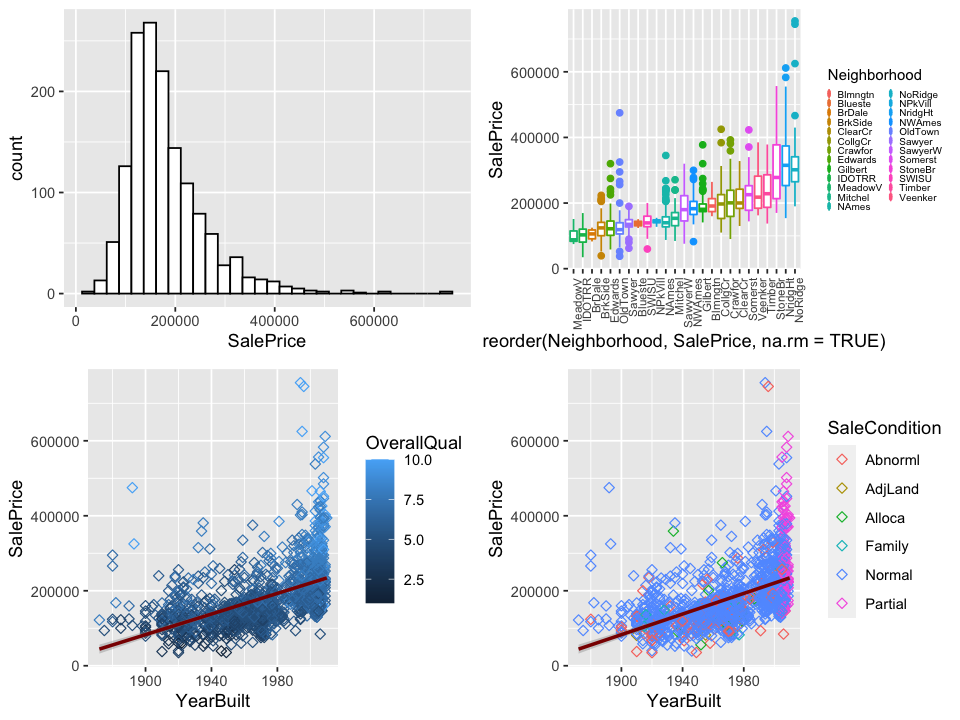

In [18]:
options(repr.plot.width=8, repr.plot.height=6, scipen=999)

ggdraw() +
  draw_plot(disstribution, 0, .5, .5, .5) +
  draw_plot(neighborhood, .5, .5, .5, .5) +
  draw_plot(quality, 0, 0, .5, .5) +
  draw_plot(sale_cond, .5, 0, .5, .5)

#options(scipen=999)

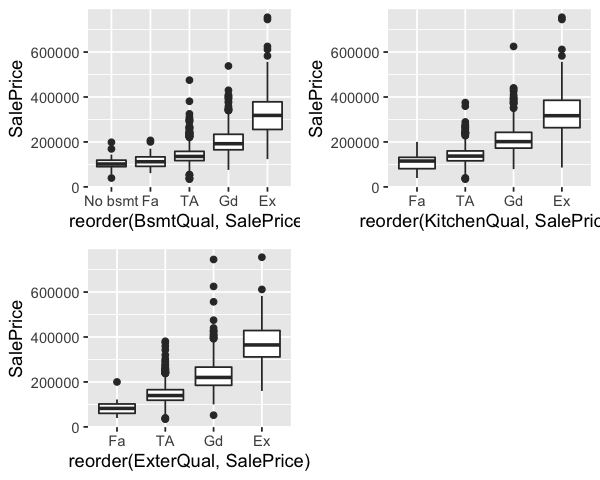

In [20]:
# few more categorical variables that have linear relationship with dependat variable

options(repr.plot.width=5, repr.plot.height=4, scipen=999)

# basement quality against SalePrice
BsmtQual <- ggplot(train_data, aes(x=reorder(BsmtQual, SalePrice), y=SalePrice)) + geom_boxplot()

# kitchen quality against SalePrice
KitchenQual <- ggplot(train_data, aes(x=reorder(KitchenQual, SalePrice), y=SalePrice)) + geom_boxplot()

# exterior quality against SalePrice
ExterQual <- ggplot(train_data, aes(x=reorder(ExterQual, SalePrice), y=SalePrice)) + geom_boxplot()

ggdraw() +
  draw_plot(BsmtQual, 0, .5, .5, .5)+
  draw_plot(KitchenQual, .5, .5, .5, .5)+
  draw_plot(ExterQual, 0, 0, .5, .5)

 * Price Distribution - Most of the price density lies between 100k and 250k, but there appears to be a lot of outliers on the pricier side. SalePrice is slightly left-skewed

* Neighborhood, Year Built, BsmtQual, KitchenQual and ExterQual - we see linear relationship with price as shown by the plots above and could be strong predictors.

* Expectedly we see an overal quality is better in the newly built houses and they seem to cost more they also have a'partial sale' condition meaning homes were not completed when last assessed

In [108]:
# visualizing categorical and numeric values separatelly 
# Checking if there is any visible linear relationship between dependant and independnt variables 

categorical <- names(train_data)[which(sapply(train_data, is.character))]
numerical <- names(train_data)[which(sapply(train_data, is.numeric))]

train_cat<-train_data[categorical]
train_num<-train_data[numerical]

In [109]:
## Bar plot function

plotHist <- function(data_in, i) 
{
  data <- data.frame(x=data_in[[i]])
  p <- ggplot(data=data, aes(x=factor(x))) + stat_count() + xlab(colnames(data_in)[i]) + theme_light() + 
    theme(axis.text.x = element_text(angle = 90, hjust =1))
  return (p)
}

## Scatter plot function for categorical variables

plotScatCat <- function(data_in, i)
{
  data <- data.frame(x=data_in[[i]], SalePrice = train$SalePrice)
  p <- ggplot(data = data, aes(x=reorder(x, SalePrice, na.rm = TRUE), y = SalePrice)) + geom_point() + xlab(colnames(data_in)[i])  + 
    theme(axis.text.x = element_text(angle = 90, hjust =1)) 
  return(p)   
}


## Scatter plot function for numeric variables

plotScatNum <- function(data_in, i)
{
  data <- data.frame(x=data_in[[i]], SalePrice = train$SalePrice)
  p <- ggplot(data = data, aes(x=reorder(x, SalePrice, na.rm = TRUE), y = SalePrice)) + geom_point() + xlab(colnames(data_in)[i])  + 
    theme(axis.text.x = element_blank(),
          axis.ticks.x = element_blank()) 
  return(p)   
}

## Density plot function

plotDen <- function(data_in, i)
{  
  data <- data.frame(x=data_in[[i]], SalePrice = data_in$SalePrice)
  p <- ggplot(data= data) + geom_line(aes(x = x), stat = 'density', size = 1,alpha = 1.0) + 
    xlab(paste0((colnames(data_in)[i]), '\n', 'Skewness: ',round(skewness(data_in[[i]], na.rm = TRUE), 2))) + theme_light() 
  return(p)
  
}


## Function to call Bar plot, Scatter plot and Density plot function

doPlots <- function(data_in, fun, ii, ncol=4) 
{
  pp <- list()
  for (i in ii) {
    p <- fun(data_in=data_in, i=i)
    pp <- c(pp, list(p))
  }
  do.call("grid.arrange", c(pp, ncol=ncol))
}

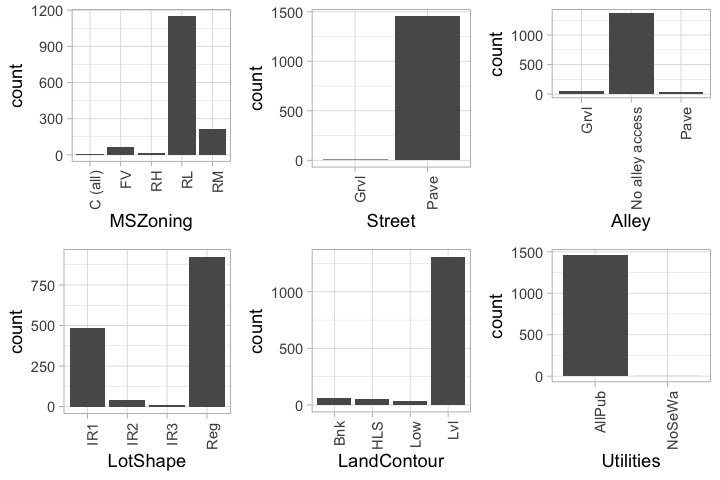

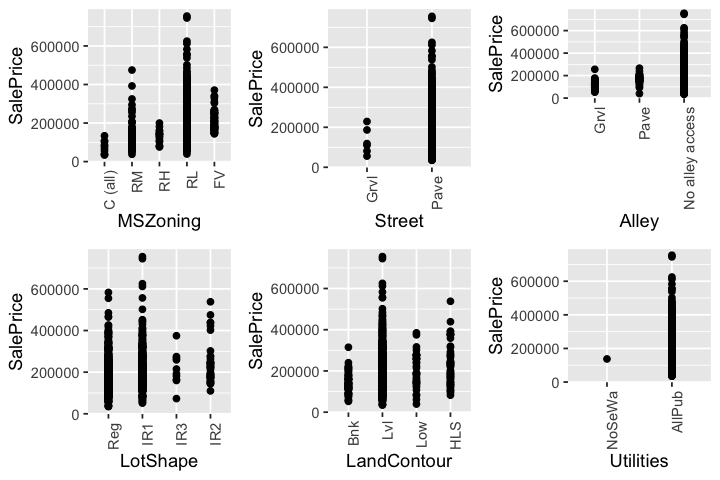

In [38]:
#Bar plots and scatter plots for the categorical features
options(repr.plot.width=6, repr.plot.height=4)

doPlots(train_cat, fun = plotHist, ii = 1:6, ncol = 3)
doPlots(train_cat, fun = plotScatCat, ii = 1:6, ncol = 3)

options(scipen=999)

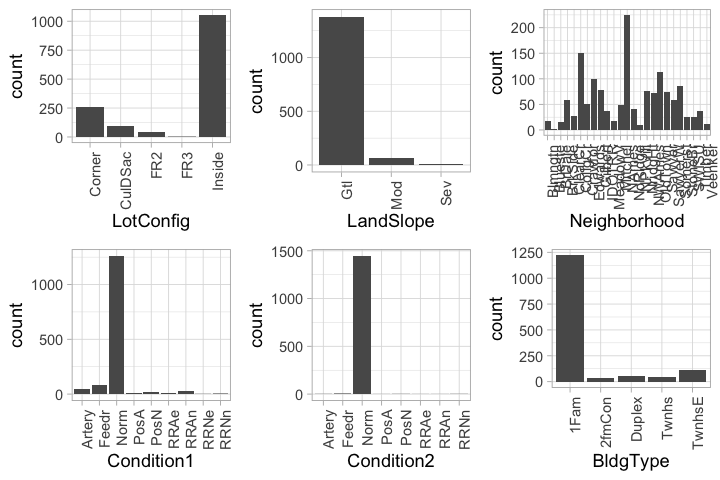

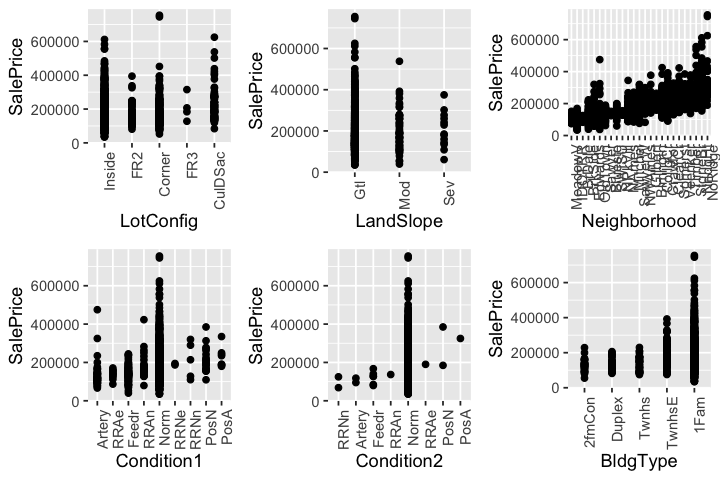

In [39]:
doPlots(train_cat, fun = plotHist, ii = 7:12, ncol = 3)
doPlots(train_cat, fun = plotScatCat, ii = 7:12, ncol = 3)

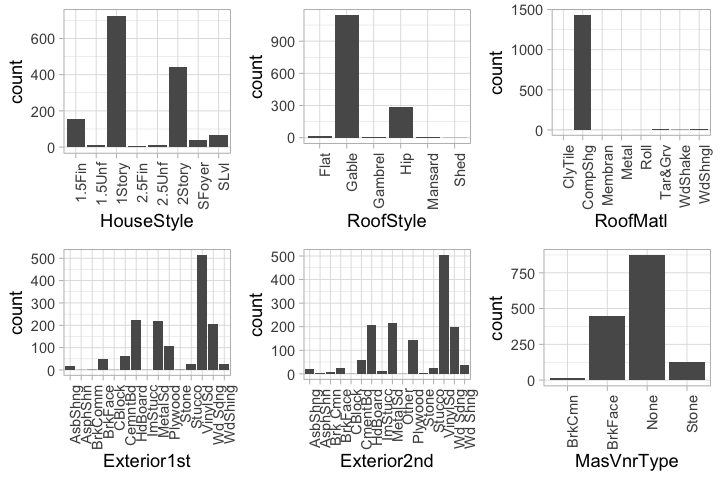

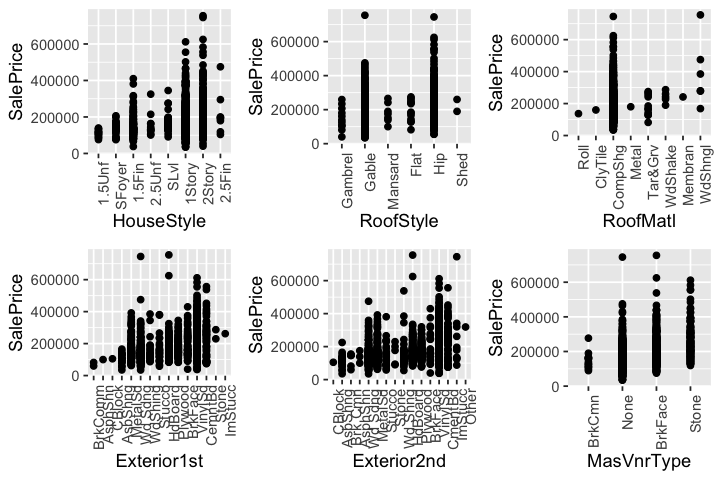

In [40]:
doPlots(train_cat, fun = plotHist, ii = 13:18, ncol = 3)
doPlots(train_cat, fun = plotScatCat, ii = 13:18, ncol = 3)

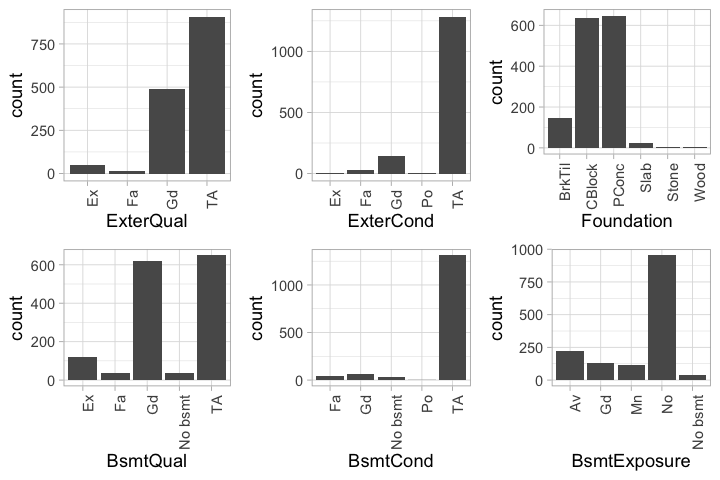

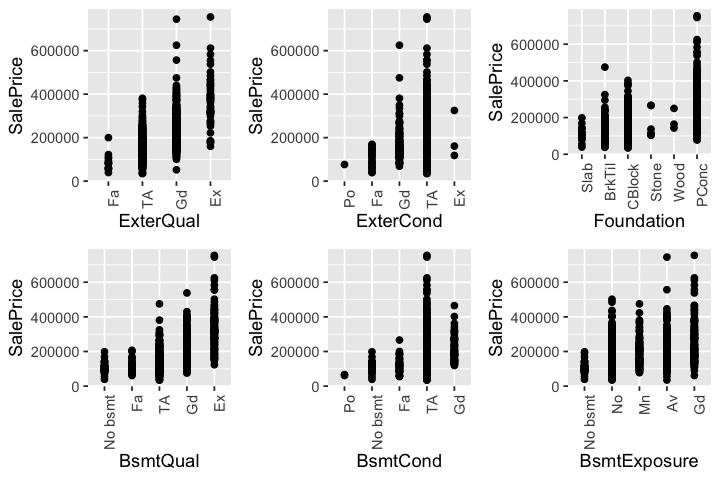

In [41]:
doPlots(train_cat, fun = plotHist, ii = 19:24, ncol = 3)
doPlots(train_cat, fun = plotScatCat, ii = 19:24, ncol = 3)

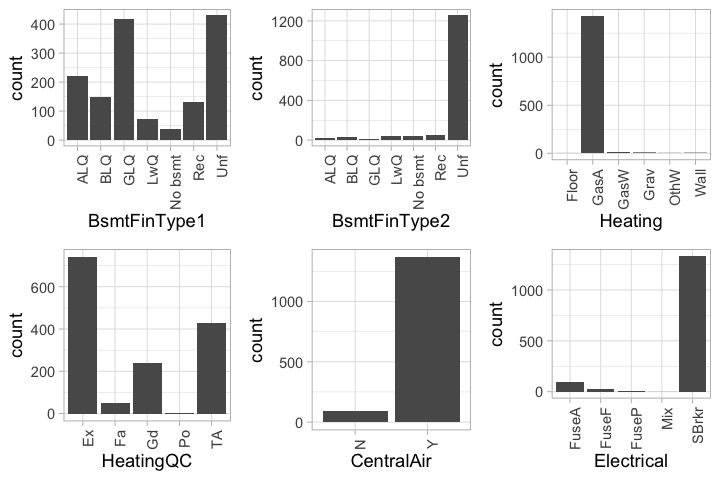

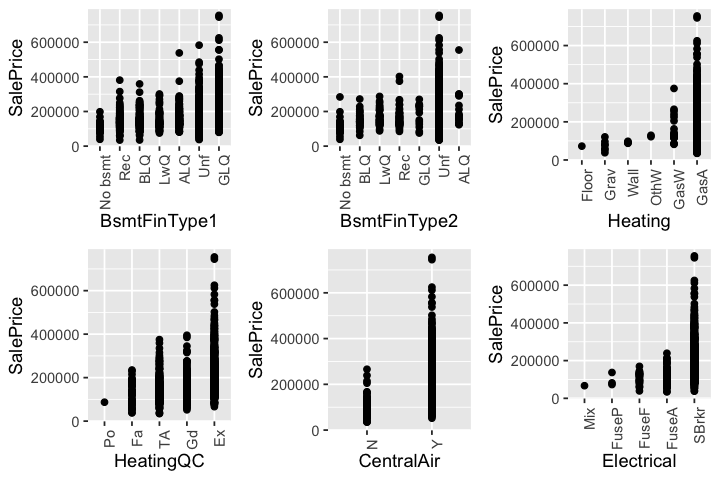

In [42]:
doPlots(train_cat, fun = plotHist, ii = 25:30, ncol = 3)
doPlots(train_cat, fun = plotScatCat, ii = 25:30, ncol = 3)

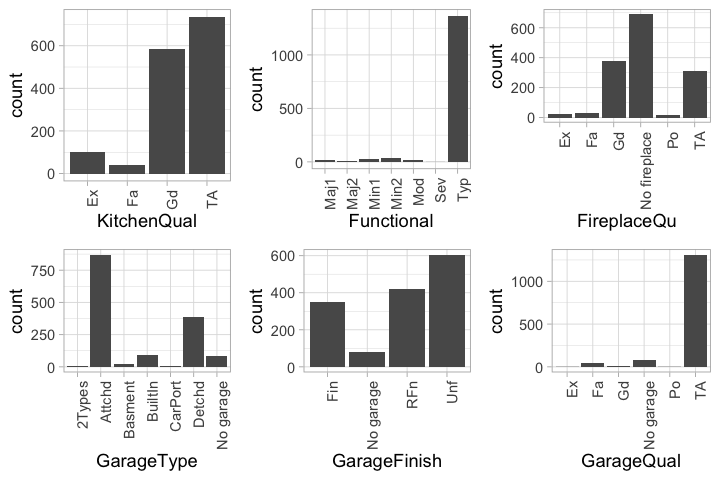

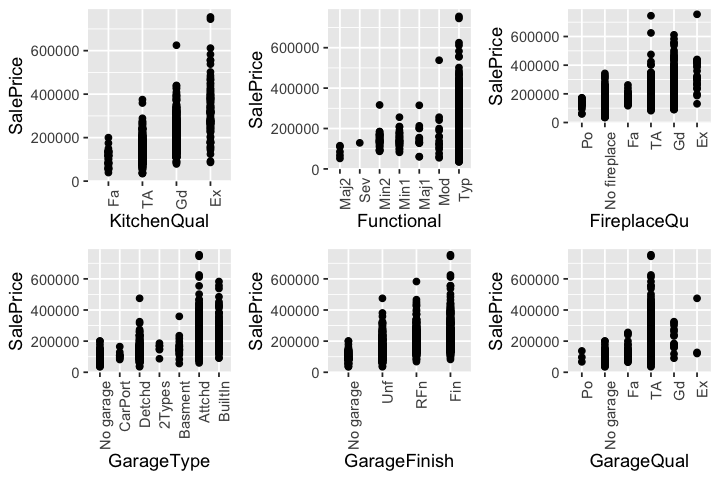

In [43]:
doPlots(train_cat, fun = plotHist, ii = 31:36, ncol = 3)
doPlots(train_cat, fun = plotScatCat, ii = 31:36, ncol = 3)

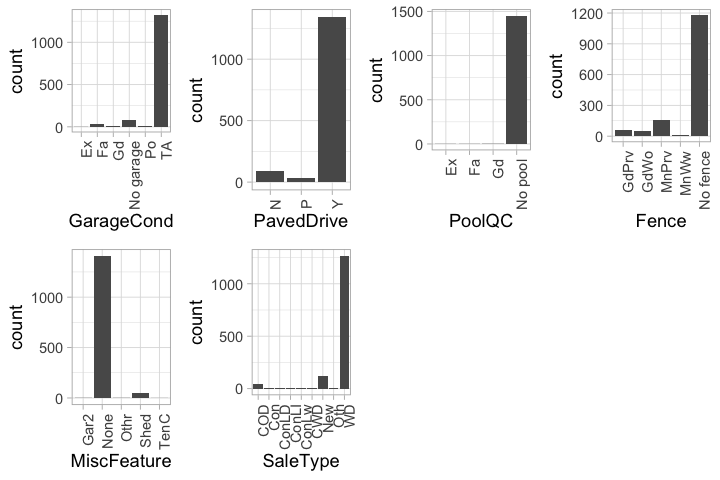

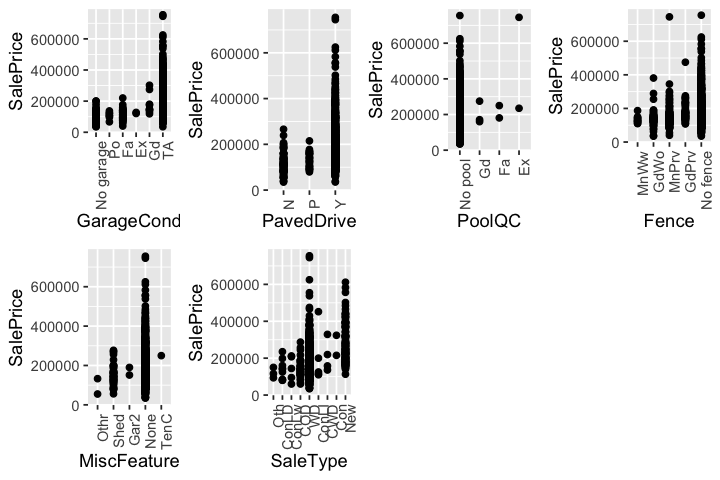

In [44]:
doPlots(train_cat, fun = plotHist, ii = 37:42, ncol = 4)
doPlots(train_cat, fun = plotScatCat, ii = 37:42, ncol = 4)

We see that a lot of categorical dependant variables have one or couple strongly dominant(most common) values.

That is also reflected in the variable vs SalePrice graphs as those dominant values cover the wide range of prices (from lowest to highest) making those variables weak predictors in predicting the price

Neighborhood, BsmtQual, ExtrQual and KitchenQual share linear relationship with dependant variable, thus making them the potential strong predictors 

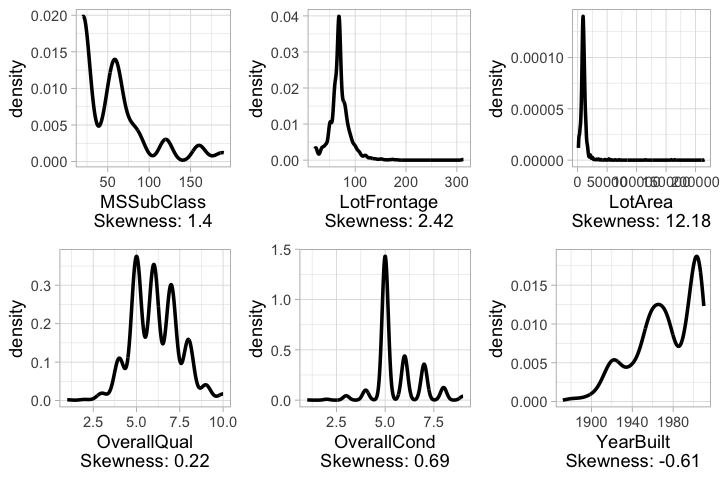

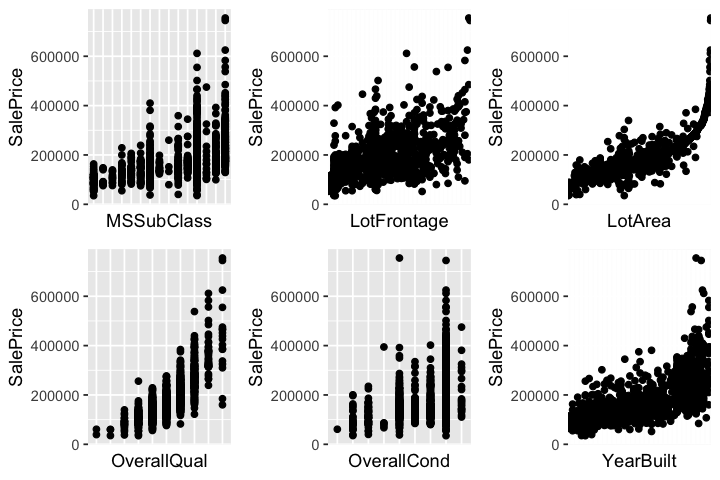

In [45]:
#Density plots for numeric variables, skipping 1 - id column 

doPlots(train_num, fun = plotDen, ii = 2:7, ncol = 3)
doPlots(train_num, fun = plotScatNum, ii = 2:7, ncol = 3)

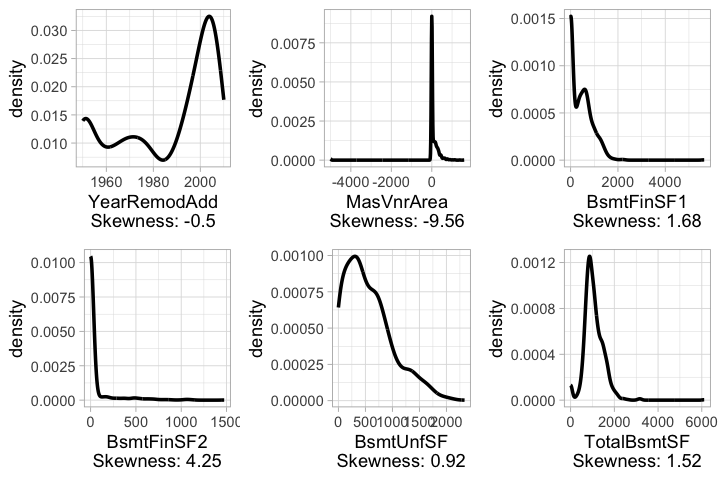

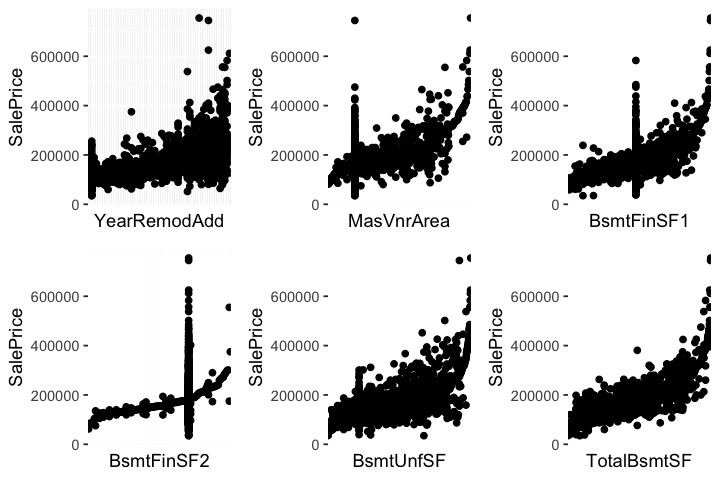

In [46]:
doPlots(train_num, fun = plotDen, ii = 8:13, ncol = 3)
doPlots(train_num, fun = plotScatNum, ii = 8:13, ncol = 3)

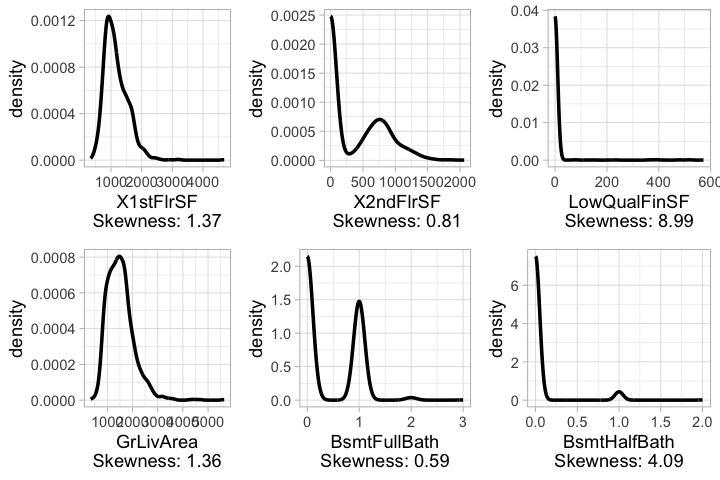

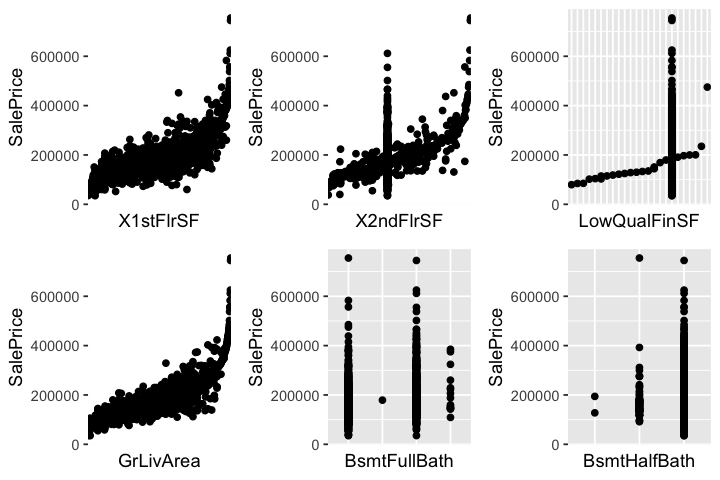

In [47]:
doPlots(train_num, fun = plotDen, ii = 14:19, ncol = 3)
doPlots(train_num, fun = plotScatNum, ii = 14:19, ncol = 3)

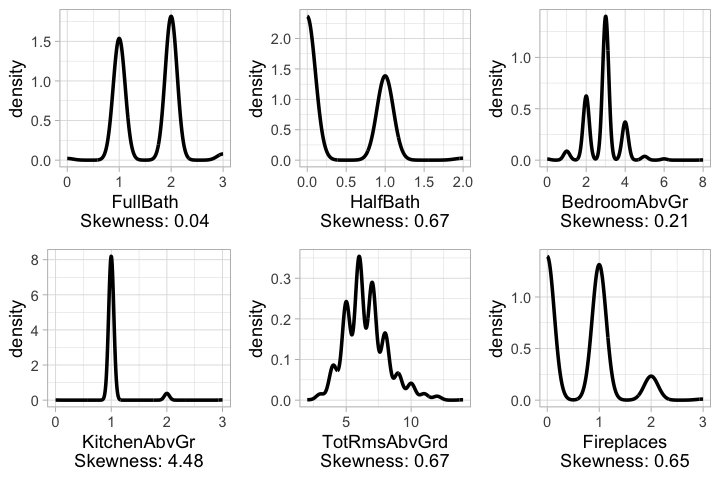

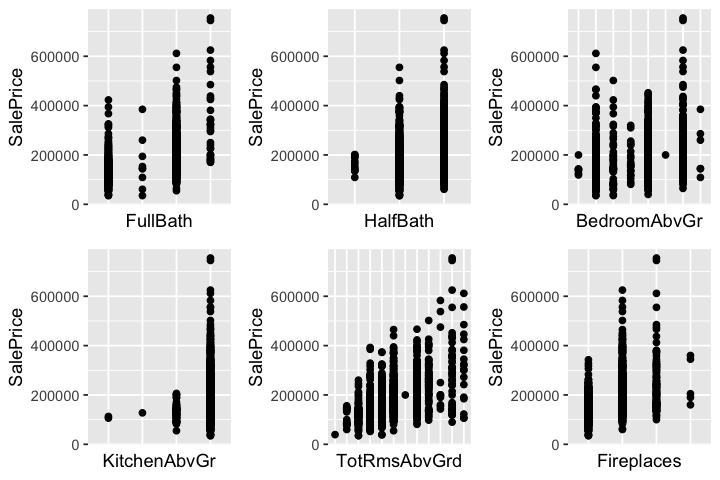

In [48]:
doPlots(train_num, fun = plotDen, ii = 20:25, ncol = 3)
doPlots(train_num, fun = plotScatNum, ii = 20:25, ncol = 3)

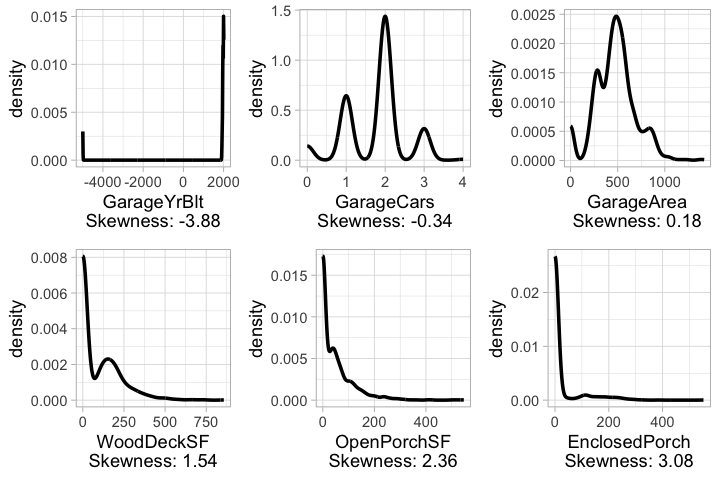

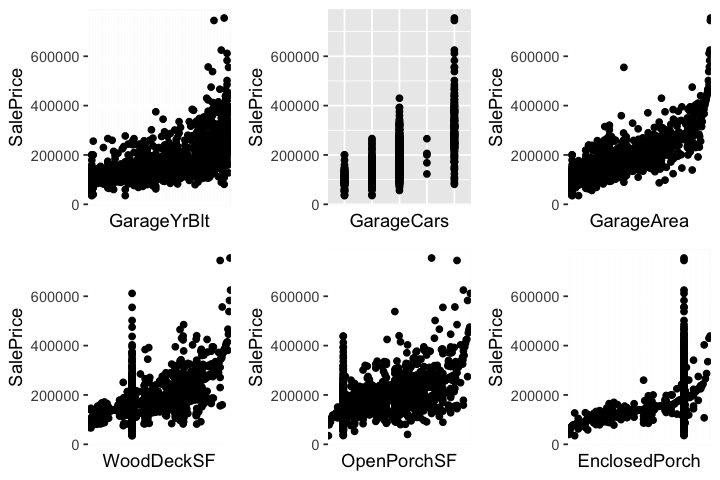

In [49]:
doPlots(train_num, fun = plotDen, ii = 26:31, ncol = 3)
doPlots(train_num, fun = plotScatNum, ii = 26:31, ncol = 3)

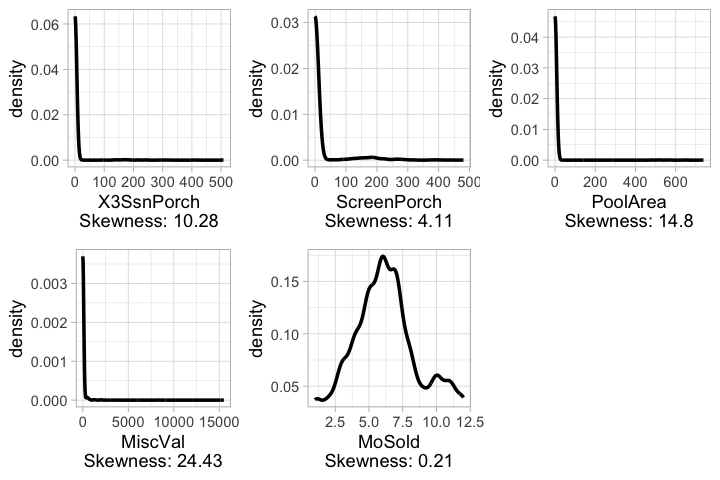

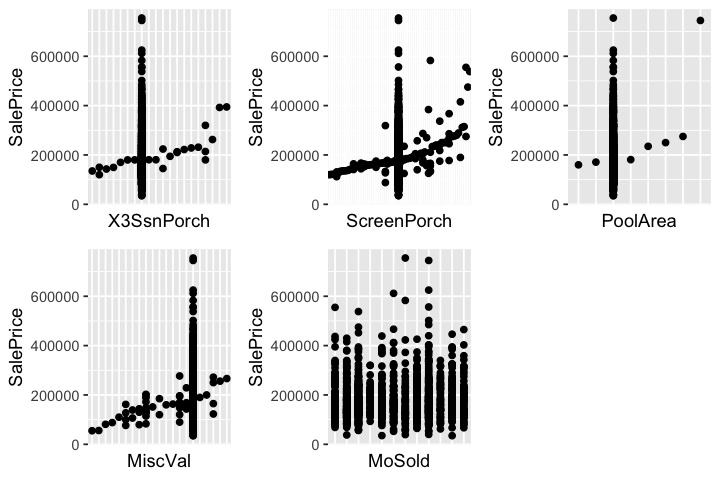

In [50]:
doPlots(train_num, fun = plotDen, ii = 32:36, ncol = 3)
doPlots(train_num, fun = plotScatNum, ii = 32:36, ncol = 3)

YearBult - we see that newer houses cost more same with YearRemod (newly renovated)

OverallQual, TotalBsmtSF, X1stFlrSF, GrLivArea, TotRmsAbvGrd, GarageCars, GarageArea, FullBath also seem like they might have a lot of predictive power for the model

# Correlation: numeric

Exploring the correlations between numeric independant and SalesPrice

In [51]:
install.packages("corrplot") 

library(corrplot)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


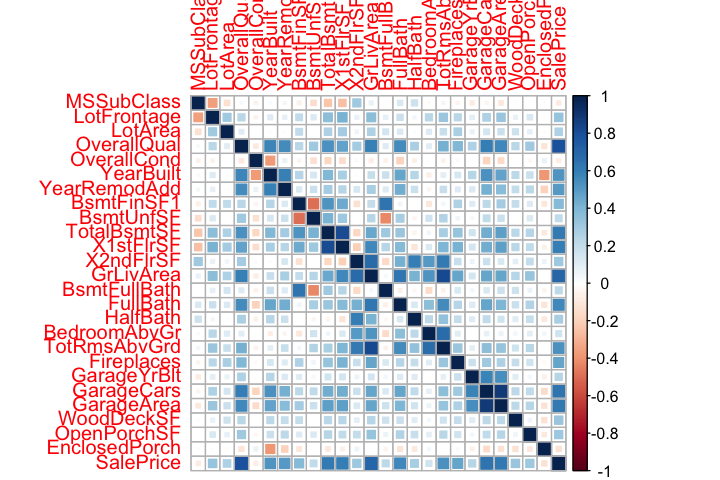

In [52]:
correlations <- cor(na.omit(train_num[,-1]))
row_indic <- apply(correlations, 1, function(x) sum(x > 0.3 | x < -0.3) > 1)
correlations<- correlations[row_indic ,row_indic ]
corrplot(correlations, method="square")

# Linear regression model

I am using the linear regression - supervised machine learning technique to predict the value of the house prices. Using training data to optimize the model, and then using the test data to validate the model. 

RMSE, AIC and BIC scores were chosen as a metric for model performance.

RMSE - measures the average error performed by the model in predicting the outcome for an observation. Optimizing for RMSE provides an accurate results. However, RMSE method is sensible to the inclusion of additional variables. Including additional variables in the model will always reduce the RMSE, even if those variables dont have significant contribution in explaining the outcome.

To overcome this, AIC and BIC scores will be calculated. They take the error term and add a penalty related to the number of predictors used in the model. 

In [72]:
install.packages(c("caret", "broom", "flexmix"))

library(caret)
library(broom)     
library(flexmix)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [115]:
# running lr model on all training data: num and cat, setting a reference point

# setting the seed to make the model reproducible
set.seed(2)

model_all <- lm(SalePrice ~ ., data = train_data)
summary(model_all)


Call:
lm(formula = SalePrice ~ ., data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-178176   -9265     240    9221  178176 

Coefficients: (8 not defined because of singularities)
                             Estimate    Std. Error t value
(Intercept)             -524518.99077 1061689.80338  -0.494
Id                            1.09871       1.55186   0.708
MSSubClass                  -46.45943      82.96710  -0.560
MSZoningFV                33368.11194   12039.89002   2.771
MSZoningRH                22913.25060   11928.37108   1.921
MSZoningRL                24937.37374   10254.00325   2.432
MSZoningRM                21698.37851    9614.58857   2.257
LotFrontage                  45.43385      43.99071   1.033
LotArea                       0.72468       0.10981   6.600
StreetPave                34099.83420   12222.67419   2.790
AlleyNo alley access      -1765.72062    4226.32998  -0.418
AlleyPave                   477.13712    6037.19717   0.079
LotShapeIR2     

In [116]:
# Residual sum of squares:
RSS <- c(crossprod(model$residuals))
# Mean squared error:
MSE <- RSS / length(model$residuals)
#Root MSE:
RMSE <- sqrt(MSE)
RMSE

[1] 20603.56

In [117]:
BIC(model_all)

[1] 34998.99

In [118]:
AIC(model_all)

[1] 33656.3

RMSE, BIC and AIC are very high - model optimisation is needed

# 3) Optimising the LR model: 1) Selecting highly informative varibales with Principal Component Analysis (PCA)

PCA allows you to capture the variables having the most variance in the dataset/capturing the most information.
So the aim is to reduce the number of variables of a data set, while preserving as much information as possible.

In [81]:
install.packages("factoextra")

library(factoextra)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


In [82]:
# getting numerical variables 
numerical <- names(train_data)[which(sapply(train_data, is.numeric))]
train_num<- train_data[numerical]
train_num[is.na(train_num)] <- 0

In [83]:
# identifying variables that had zero or near-zero variance.
zero_nearZero <- nearZeroVar(train_num, saveMetrics = T)
head(zero_nearZero)

freqRatio percentUnique zeroVar nzv  
Id          1.000000  100.0000000   FALSE   FALSE
MSSubClass  1.792642    1.0273973   FALSE   FALSE
LotFrontage 1.944056    7.5342466   FALSE   FALSE
LotArea     1.041667   73.4931507   FALSE   FALSE
OverallQual 1.061497    0.6849315   FALSE   FALSE
OverallCond 3.257937    0.6164384   FALSE   FALSE

In [84]:
# getting rows with near-zero variance 
remove <- zero_nearZero[zero_nearZero$nzv == 1,]
# getting names of those columns
remove <- rownames(remove)
# adding Id column to remove list
remove <- append(remove, c("Id"))
remove

[1] "BsmtFinSF2"    "LowQualFinSF"  "KitchenAbvGr"  "EnclosedPorch"
[5] "X3SsnPorch"    "ScreenPorch"   "PoolArea"      "MiscVal"      
[9] "Id"

In [85]:
# removing the columns with near-zero variance
PCA = train_num[, !(names(train_num) %in% remove)]

In [86]:
#performing PCA 
PCA = prcomp(train_num, scale = T, center = T)
# and geting eigenvalues which shows how much variance (how spread out) there is in the data in that direction
eigenvalues = factoextra::get_eigenvalue(PCA)
head(eigenvalues)

eigenvalue variance.percent cumulative.variance.percent
Dim.1 7.489023   19.707956        19.70796                   
Dim.2 3.191939    8.399840        28.10780                   
Dim.3 2.280813    6.002139        34.10993                   
Dim.4 2.025530    5.330341        39.44028                   
Dim.5 1.553259    4.087523        43.52780                   
Dim.6 1.317465    3.467013        46.99481

In [87]:
# ideally we want eigenvalues above 1, eigenvalue > 1 indicates that PCs account for more variance than 
# accounted by one of the original variables in standardized data.
# I will get top 15 principal components and correlations between variables and those components
pcaVar = factoextra::get_pca_var(PCA) #PCA variables
pcaVar = as.data.frame(c(pcaVar))[,1:15] #table of correlations between variables and top 15 principal components
head(pcaVar)

coord.Dim.1 coord.Dim.2 coord.Dim.3  coord.Dim.4 coord.Dim.5
Id           0.00473834 -0.02849442  0.007394819 -0.01065283  0.01215255
MSSubClass   0.06931292 -0.34324104 -0.305063091 -0.41303564  0.38908856
LotFrontage -0.44409853  0.06864445  0.424241909  0.18932627 -0.11759404
LotArea     -0.30993464  0.10893244  0.426267186 -0.04772987 -0.09077590
OverallQual -0.80710797  0.01843330 -0.234426104  0.01569887 -0.04218809
OverallCond  0.17991620 -0.06424965  0.178208934 -0.15103232 -0.45397399
            coord.Dim.6 coord.Dim.7  coord.Dim.8 coord.Dim.9 coord.Dim.10
Id          -0.19029827  0.138851886 -0.24648576 -0.18397860  0.3065585  
MSSubClass  -0.05865117  0.135754650  0.11371932  0.09544062  0.2308556  
LotFrontage -0.07725765 -0.109917231 -0.09195627 -0.13012248 -0.2647195  
LotArea     -0.03309039 -0.043632588  0.14379202  0.02166593 -0.1925761  
OverallQual  0.18751381 -0.007449197 -0.06222353 -0.03688665  0.1103379  
OverallCond  0.26934198 -0.206118126  0.22173252 -0.22331145  0.4646565  
            coord.Dim.11 coord.Dim.12 coord.Dim.13 coord.Dim.14 coord.Dim.15
Id           0.321502254  0.268673988 -0.410814716 -0.343664447 -0.19135110 
MSSubClass  -0.304910087 -0.001295771  0.002267213 -0.032412169  0.09125192 
LotFrontage  0.223646596 -0.084197593 -0.095362407  0.012697171  0.09205145 
LotArea      0.146763224  0.093691976  0.098731073  0.208944272 -0.01589544 
OverallQual -0.125312045 -0.024254733  0.035631694 -0.001449109 -0.04206142 
OverallCond  0.002851098 -0.055164060  0.025675009 -0.107861515 -0.14148196

In [88]:
# finding the variables that have correlations higher than -0.50 or 0.50 with the corresponding individual Principal Components. 
# The variables that have high correlations with the first Principal Components will be highly informative. 
var = pcaVar[FALSE, ]
k = 1
for(i in colnames(pcaVar))
{
  for(j in rownames(pcaVar))
    {
      if(abs(pcaVar[j , i]) >= 0.5) #strong +ve/-ve correlation between variables j and i
        {
          var[k, i] = j
          k = k + 1
        }
    }
  k = 1
}
var = as.data.frame(var)
var

coord.Dim.1  coord.Dim.2  coord.Dim.3 coord.Dim.4  coord.Dim.5  coord.Dim.6
1  OverallQual  BsmtFinSF1   YearBuilt   BsmtUnfSF    KitchenAbvGr GarageYrBlt
2  YearBuilt    X2ndFlrSF    NA          BsmtFullBath NA           NA         
3  YearRemodAdd BsmtFullBath NA          NA           NA           NA         
4  TotalBsmtSF  BedroomAbvGr NA          NA           NA           NA         
5  X1stFlrSF    TotRmsAbvGrd NA          NA           NA           NA         
6  GrLivArea    NA           NA          NA           NA           NA         
7  FullBath     NA           NA          NA           NA           NA         
8  TotRmsAbvGrd NA           NA          NA           NA           NA         
9  Fireplaces   NA           NA          NA           NA           NA         
10 GarageCars   NA           NA          NA           NA           NA         
11 GarageArea   NA           NA          NA           NA           NA         
12 SalePrice    NA           NA          NA           NA           NA         
   coord.Dim.7 coord.Dim.8  coord.Dim.9 coord.Dim.10 coord.Dim.11 coord.Dim.12
1  MoSold      BsmtHalfBath ScreenPorch NA           NA           X3SsnPorch  
2  YrSold      NA           NA          NA           NA           NA          
3  NA          NA           NA          NA           NA           NA          
4  NA          NA           NA          NA           NA           NA          
5  NA          NA           NA          NA           NA           NA          
6  NA          NA           NA          NA           NA           NA          
7  NA          NA           NA          NA           NA           NA          
8  NA          NA           NA          NA           NA           NA          
9  NA          NA           NA          NA           NA           NA          
10 NA          NA           NA          NA           NA           NA          
11 NA          NA           NA          NA           NA           NA          
12 NA          NA           NA          NA           NA           NA          
   coord.Dim.13 coord.Dim.14 coord.Dim.15
1  PoolArea     MiscVal      NA          
2  NA           NA           NA          
3  NA           NA           NA          
4  NA           NA           NA          
5  NA           NA           NA          
6  NA           NA           NA          
7  NA           NA           NA          
8  NA           NA           NA          
9  NA           NA           NA          
10 NA           NA           NA          
11 NA           NA           NA          
12 NA           NA           NA

The variables that capure the most of information are listent in coord.Dim.1 column  

# 3) Optimising the LR model: 2) Selecting the features that correlate with SalePrice

In [89]:
# after examining distribution some of the features were weakly correlated, there were a lot of overlap between the boxes in boxplots or only one feature dominates the market covering the whole range of SalePrice.
# I was left with 11 features that correlates with SalePrice
train_corr <- select(train_num, OverallQual, YearBuilt, YearRemodAdd, TotalBsmtSF, X1stFlrSF, GrLivArea, FullBath, TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, SalePrice)   

train_num_correl<-cor(train_corr)
head(round(train_num_correl,2))

OverallQual YearBuilt YearRemodAdd TotalBsmtSF X1stFlrSF GrLivArea
OverallQual  1.00        0.57      0.55         0.54        0.48      0.59     
YearBuilt    0.57        1.00      0.59         0.39        0.28      0.20     
YearRemodAdd 0.55        0.59      1.00         0.29        0.24      0.29     
TotalBsmtSF  0.54        0.39      0.29         1.00        0.82      0.45     
X1stFlrSF    0.48        0.28      0.24         0.82        1.00      0.57     
GrLivArea    0.59        0.20      0.29         0.45        0.57      1.00     
             FullBath TotRmsAbvGrd Fireplaces GarageCars GarageArea SalePrice
OverallQual  0.55     0.43         0.40       0.60       0.56       0.79     
YearBuilt    0.47     0.10         0.15       0.54       0.48       0.52     
YearRemodAdd 0.44     0.19         0.11       0.42       0.37       0.51     
TotalBsmtSF  0.32     0.29         0.34       0.43       0.49       0.61     
X1stFlrSF    0.38     0.41         0.41       0.44       0.49       0.61     
GrLivArea    0.63     0.83         0.46       0.47       0.47       0.71

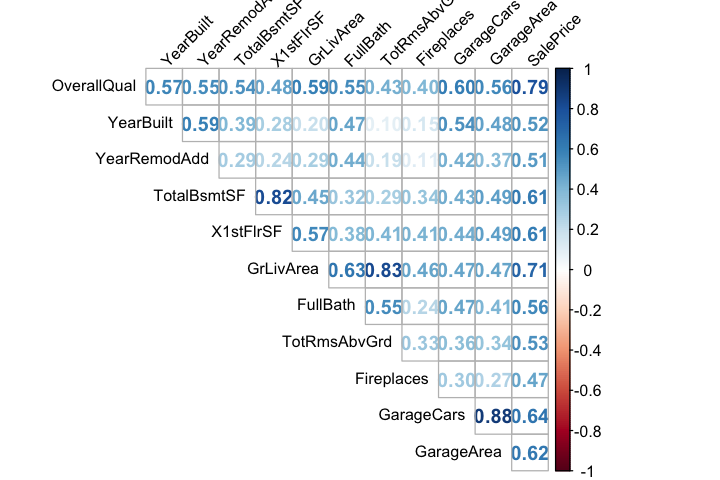

In [90]:
options(repr.plot.width=6, repr.plot.height=4)
corrplot(train_num_correl, method="number", addCoef.col = "black", tl.col="black", tl.srt=45, type = 'upper', diag = FALSE, tl.cex = 0.8)

All variables that correlate with dependant varable (SalePrice) share high correlations with the first Principal Component and most likely will be highly informative and therefore included in my model.

From the correlation matrix we see the presence of multicollinearity. TotalBsmtSF variable highly correlates with X1stFlrSF, therefore will be removed. GrLivArea variable corelates more with SalePrice than FullBath and TotRmsAbvGrd. Since latter two highly correlate with GrLivArea, they will be removed. GarageCars and GarageArea correlate with each other as well, GarageCars correlates slightly more with other features, therefore will be excluded from the model.

In [91]:
# removing variables with high multicollinearity and adding categorical features correlating to SalePrice
cat_num_corr <- select(Data, OverallQual, YearBuilt, YearRemodAdd, X1stFlrSF, GrLivArea, Fireplaces, GarageArea, Neighborhood, BsmtQual, KitchenQual, ExterQual, BsmtQual, GarageFinish, SalePrice)   

In [119]:
# seperating dataset back to train and test subsets to run test lm 
test_cat_num_corr <- cat_num_corr[is.na(cat_num_corr$SalePrice), ]  
train_cat_num_corr <- cat_num_corr[!is.na(cat_num_corr$SalePrice), ]  

In [120]:
set.seed(2)

model_corr <- lm(SalePrice ~ OverallQual + YearBuilt + YearRemodAdd + X1stFlrSF + GrLivArea +
            Fireplaces + GarageArea + Neighborhood + BsmtQual +
            KitchenQual + ExterQual + BsmtQual + GarageFinish, data = train_cat_num_corr)

summary(model_corr)


Call:
lm(formula = SalePrice ~ OverallQual + YearBuilt + YearRemodAdd + 
    X1stFlrSF + GrLivArea + Fireplaces + GarageArea + Neighborhood + 
    BsmtQual + KitchenQual + ExterQual + BsmtQual + GarageFinish, 
    data = train_cat_num_corr)

Residuals:
    Min      1Q  Median      3Q     Max 
-407621  -14576     304   12972  232353 

Coefficients:
                         Estimate  Std. Error t value             Pr(>|t|)    
(Intercept)           -563282.444  178050.651  -3.164             0.001591 ** 
OverallQual             10248.759    1201.223   8.532 < 0.0000000000000002 ***
YearBuilt                 121.038      71.274   1.698             0.089688 .  
YearRemodAdd              207.763      61.627   3.371             0.000768 ***
X1stFlrSF                  14.212       3.181   4.468   0.0000085222647193 ***
GrLivArea                  39.449       2.543  15.512 < 0.0000000000000002 ***
Fireplaces               8798.075    1645.679   5.346   0.0000001046122139 ***
GarageArea       

In [121]:
# Residual sum of squares:
RSS <- c(crossprod(model_corr$residuals))
# Mean squared error:
MSE <- RSS / length(model_corr$residuals)
#Root MSE:
RMSE <- sqrt(MSE)
RMSE

[1] 31646.49

In [122]:
BIC(model_corr)

[1] 34736.62

In [123]:
AIC(model_corr)

[1] 34493.46

RMSE is slightly higher, reducing the number of predictors increases RMSE score, BIC and AIC haven't changed much  - needs optimising even more

# 3) Optimising the LR model: 3) log-transforming skewed variables¶

Linear regression assumes that all variables are normally distributed. log transforming features that have a highly skewed distribution (skew > .75)

In [124]:
column_classes <- sapply(names(cat_num_corr), function(x){class(cat_num_corr[[x]])})
numeric_columns <- names(column_classes[column_classes == "integer"])
# determining skew of each numric variable
skew <- sapply(numeric_columns, function(x){skewness(cat_num_corr[[x]], na.rm = T)})
# determining a threshold skewness
skew <- skew[skew > 0.75]

In [125]:
# transforming excessively skewed features with log(x + 1)
cat_num_log = cat_num_corr
for(x in names(skew)) 
{
  cat_num_log[[x]] = log(cat_num_log[[x]] + 1)
  
}

In [126]:
# converting matric to df
cat_num_log <- as.data.frame(cat_num_log)

In [127]:
# seperating dataset back to train and test subsets to run test lm 
test_log <- cat_num_log[is.na(cat_num_log$SalePrice), ]  
train_log <- cat_num_log[!is.na(cat_num_log$SalePrice), ]  

In [128]:
set.seed(2)

model_log <- lm(SalePrice ~ OverallQual + YearBuilt + YearRemodAdd + X1stFlrSF + GrLivArea +
            Fireplaces + GarageArea + Neighborhood + BsmtQual +
            KitchenQual + ExterQual + BsmtQual + GarageFinish, data = train_log)

summary(model_log)


Call:
lm(formula = SalePrice ~ OverallQual + YearBuilt + YearRemodAdd + 
    X1stFlrSF + GrLivArea + Fireplaces + GarageArea + Neighborhood + 
    BsmtQual + KitchenQual + ExterQual + BsmtQual + GarageFinish, 
    data = train_log)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.37076 -0.06754  0.01069  0.08009  0.48763 

Coefficients:
                         Estimate  Std. Error t value             Pr(>|t|)    
(Intercept)            2.70737667  0.81527044   3.321             0.000920 ***
OverallQual            0.06034779  0.00538978  11.197 < 0.0000000000000002 ***
YearBuilt              0.00100418  0.00031747   3.163             0.001595 ** 
YearRemodAdd           0.00189594  0.00027534   6.886    0.000000000008611 ***
X1stFlrSF              0.11534931  0.01740623   6.627    0.000000000048598 ***
GrLivArea              0.33070331  0.01771451  18.668 < 0.0000000000000002 ***
Fireplaces             0.04550265  0.00734386   6.196    0.000000000757861 ***
GarageArea      

In [129]:
# Residual sum of squares:
RSS <- c(crossprod(model_log$residuals))
# Mean squared error:
MSE <- RSS / length(model_log$residuals)
#Root MSE:
RMSE <- sqrt(MSE)
RMSE

[1] 0.141389

In [130]:
BIC(model_log)

[1] -1233.756

In [131]:
AIC(model_log)

[1] -1476.921

RMSE drastically improved, so did BIC and AIC. Let's see if we can improve the scores 

# 3) Optimising the LR model: 4) removing outliers using cook's distance

Removing any point over 4/n - a possible outlier (n is the number of observations)

In [153]:
# influential row numbers
cooksd <- cooks.distance(model_log)

sample_size <- nrow(train_log)
sample_size <- nrow(test_log)

influential <- as.numeric(names(cooksd)[(cooksd > (4/sample_size))])

In [154]:
train_log_cooksd <- train_log[-influential,]
test_log_cooksd <- test_log[-influential,]

In [136]:
set.seed(2)

model_out <- lm(SalePrice ~ OverallQual + YearBuilt + YearRemodAdd + X1stFlrSF + GrLivArea +
            Fireplaces + GarageArea + Neighborhood + BsmtQual +
            KitchenQual + ExterQual + BsmtQual + GarageFinish, data = train_log_cooksd)

summary(model_out)


Call:
lm(formula = SalePrice ~ OverallQual + YearBuilt + YearRemodAdd + 
    X1stFlrSF + GrLivArea + Fireplaces + GarageArea + Neighborhood + 
    BsmtQual + KitchenQual + ExterQual + BsmtQual + GarageFinish, 
    data = train_log_cooksd)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37565 -0.06556  0.00347  0.07040  0.30392 

Coefficients:
                         Estimate  Std. Error t value             Pr(>|t|)    
(Intercept)            1.89170293  0.62596593   3.022             0.002559 ** 
OverallQual            0.05172035  0.00411458  12.570 < 0.0000000000000002 ***
YearBuilt              0.00153751  0.00024854   6.186 0.000000000818809282 ***
YearRemodAdd           0.00179272  0.00020749   8.640 < 0.0000000000000002 ***
X1stFlrSF              0.12782454  0.01288412   9.921 < 0.0000000000000002 ***
GrLivArea              0.32097784  0.01336299  24.020 < 0.0000000000000002 ***
Fireplaces             0.04809364  0.00544522   8.832 < 0.0000000000000002 ***
GarageAre

In [137]:
# Residual sum of squares:
RSS <- c(crossprod(model_out$residuals))
# Mean squared error:
MSE <- RSS / length(model_out$residuals)
#Root MSE:
RMSE <- sqrt(MSE)
RMSE

[1] 0.1014877

In [138]:
BIC(model_out)

[1] -2065.944

In [139]:
AIC(model_out)

[1] -2301.156

RMSE, BIC and AIC significantly improved after removing 73 influencial data points.

In [141]:
library("ggpubr")

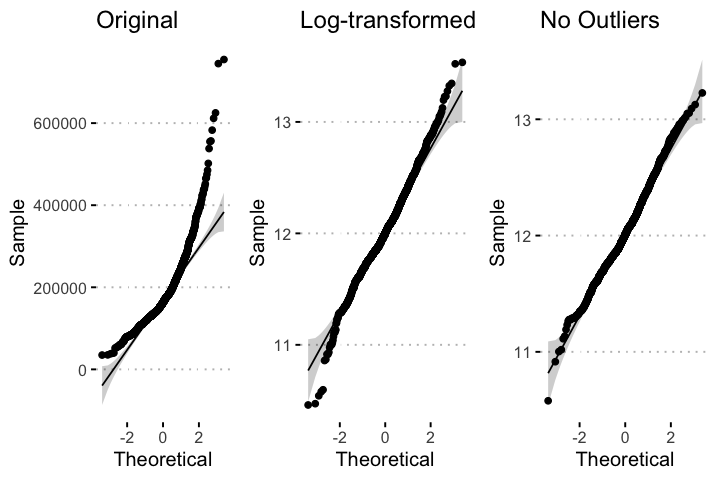

In [142]:
# checking differently modified data linear fit

options(scipen=999)

a <- ggqqplot(train_data, x = 'SalePrice',
   ggtheme = theme_pubclean()) + ggtitle("Original")

b <- ggqqplot(train_log, x = 'SalePrice',
   ggtheme = theme_pubclean()) +  ggtitle("Log-transformed")

c <- ggqqplot(train_log_cooksd, x = 'SalePrice',
   ggtheme = theme_pubclean()) +  ggtitle("No Outliers")

ggpubr::ggarrange(a,b,c, nrow = 1, align = "h")


Log-transformed data with removed outliers better fit regression line

# Testing multicollinearity 

After removing few variables that contribute to multicollinearity, let's see how significant it still is

In [143]:
install.packages("mctest")
library(mctest)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [145]:
# computing different overall measures of multicollinearity diagnostics
omcdiag(model_out)


Call:
omcdiag(mod = model_out)


Overall Multicollinearity Diagnostics

                       MC Results detection
Determinant |X'X|:         0.0000         1
Farrar Chi-Square:     27700.7927         1
Red Indicator:             0.1756         0
Sum of Lambda Inverse:   216.9684         1
Theil's Method:           -8.7020         0
Condition Number:        945.8031         1

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test


The above output shows that multicollinearity is present in the model.

In [146]:
# Looking deeper into teach individual predictor
imcdiag(model_out, method = "VIF")


Call:
imcdiag(mod = model_out, method = "VIF")


 VIF Multicollinearity Diagnostics

                          VIF detection
OverallQual            3.9087         0
YearBuilt              6.9615         0
YearRemodAdd           2.3406         0
X1stFlrSF              2.0432         0
GrLivArea              2.3621         0
Fireplaces             1.5558         0
GarageArea             2.4934         0
NeighborhoodBrDale     2.3565         0
NeighborhoodBrkSide    5.5409         0
NeighborhoodClearCr    2.7201         0
NeighborhoodCollgCr    9.8943         0
NeighborhoodCrawfor    4.5420         0
NeighborhoodEdwards    7.6092         0
NeighborhoodGilbert    5.9949         0
NeighborhoodIDOTRR     3.5117         0
NeighborhoodMeadowV    2.1834         0
NeighborhoodMitchel    4.2792         0
NeighborhoodNAmes     15.3547         1
NeighborhoodNoRidge    3.5347         0
NeighborhoodNPkVill    1.6785         0
NeighborhoodNridgHt    5.9975         0
NeighborhoodNWAmes     5.9493     

As general rule of thumb - VIF of over 10 indicates that the variable have high correlation with multiple regression variables. Usually, VIF value of less than 4 is considered good for a model. Allmost all numeric predictors have a VIF score of <4 except YearBuilt. Since it has a VIF score of <10, is significant feature in the model, and has a strong linear relationship with dependant value, I will not exlude it from the model.


# Diagnostic Plots

The plot of 'Residuals versus Fitted'(predicted) values is useful for checking the assumption of linearity and homoscedasticity. If the model does not meet the linear model assumption, we would expect to see residuals that are very large (big positive value or big negative value). To assess the assumption of linearity we want to ensure that the residuals are not too far away from 0 (standardized values less than -2 or greater than 2 are deemed problematic). To assess if the homoscedasticity assumption is met we look to make sure that there is no pattern in the residuals and that they are equally spread around the y = 0 line.

The normality assumption is evaluated based on the residuals and can be evaluated using a QQ-plot by comparing the residuals to "ideal" normal observations. Observations lie well along the 45-degree line in the QQ-plot, so we may assume that normality holds here.

The third plot is a scale-location plot (square rooted standardized residual vs. predicted value). This is useful for checking the assumption of homoscedasticity. In this particular plot we are checking to see if there is a pattern in the residuals.

The fourth plot is of "Cook's distance", which is a measure of the influence of each observation on the regression coefficients. The Cook's distance statistic is a measure, for each observation in turn, of the extent of change in model estimates when that particular observation is omitted. Any observation for which the Cook's distance is close to 1 or more, or that is substantially larger than other Cook's distances (highly influential data points), requires investigation.

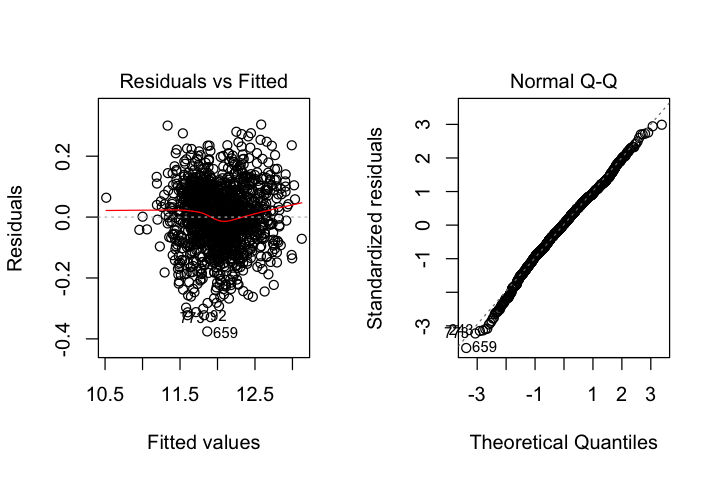

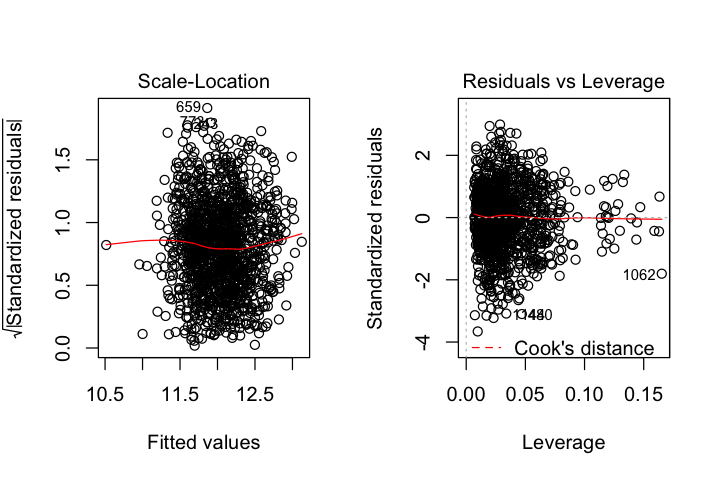

In [147]:
par(mfrow=c(1,2))  
plot(model_out)

The plots look fine 

# Visualizing the model

In [149]:
library(plotly)

In [151]:
options(repr.plot.width=4, repr.plot.height=3)
# visualizing model 

pl1 <-train_log_cooksd %>% 
  ggplot(aes(SalePrice, predict(model_out,train_log_cooksd))) +
  geom_point(alpha=0.5) + 
  stat_smooth(aes(colour='black')) +
  xlab('Actual value of SalePrice') +
  ylab('Predicted value of SalePrice')+
  theme_bw()

ggplotly(pl1)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


HTML widgets cannot be represented in plain text (need html)

# Running LR model on test data

In [160]:
# removing empty SalePrice collumn
test <- subset(test_log_cooksd, select = -SalePrice )

In [161]:
# correcting every single failing factor
is.prone <- function(x) is.factor(x) | is.character(x)

id <- sapply(test, is.prone)
model_out$xlevels <- Map(union, model_out$xlevels, lapply(test[id], unique))

In [162]:
# predicting prices for test data set 
test$predicted.SalePrice <- predict(model_out,test)

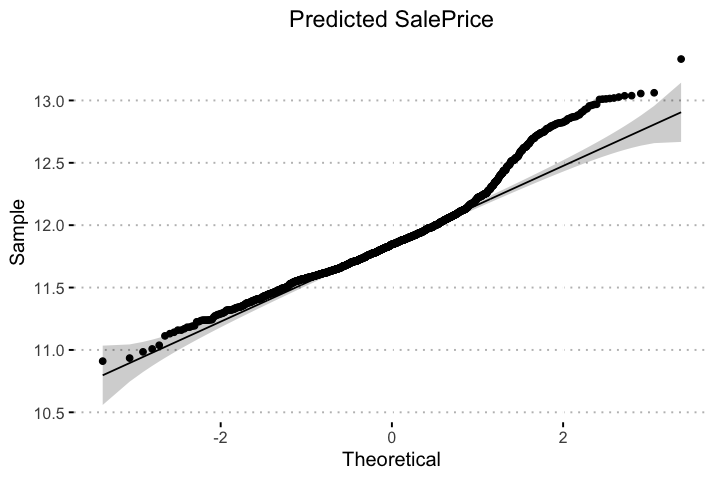

In [163]:
library(ggpubr)
options(repr.plot.width=6, repr.plot.height=4)
#options(repr.plot.width=8, repr.plot.height=6, scipen=999)
ggqqplot(test, x = 'predicted.SalePrice',
   ggtheme = theme_pubclean()) + labs(title = "Predicted SalePrice") + theme(plot.title = element_text(hjust = 0.5, size = 14))


Majority of the datapoints lie within regression line. It looks like the model is slightly off with higher SalePrice values, further investigation should be carried out to find out what is causing it 

# Conclusion 


Overal, the model fits data pretty well:

Adj. R-squared - 0.919

RMSE - 0.101
BIC - -2065.9
AIC - -2301.1

Further investigations should be carried out to identify what causes model to perform poorer on the higher SalePrice values